In [2]:
import json
import cv2 as cv
import pickle as pkl
from typing import Dict, List
import numpy as np
from matplotlib import pyplot as plt
import os, sys
import librosa
import scipy.stats as ss
from scipy import stats, spatial, ndimage

sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, "/Users/evanpan/Documents/GitHub/EvansToolBox/Utils")

from Speech_Data_util import Sentence_word_phone_parser
from Signal_processing_utils import intensity_from_signal, pitch_from_signal, sparse_key_smoothing, laplacian_smoothing
from prototypes.InputDataStructures import Dietic_Conversation_Gaze_Scene_Info
from prototypes.MVP.MVP_static_saliency_list import ObjectBasedFixSaliency
from prototypes.MVP.MVP_Aversion_saliency_list import AversionSignalDrivenSaliency, CTSAversionSignalDrivenSaliency
from prototypes.MVP.MVP_look_at_point_planner import HabituationBasedPlanner, RandomPlanner, PartnerHabituationPlanner
from prototypes.MVP.MVP_eye_head_driver import HeuristicGazeMotionGenerator
from prototypes.MVP.MVP_Aversion_saliency_list import Base_Static_Saliency_List
from prototypes.EyeCatch.Saccade_model_with_internal_model import *
from prototypes.Gaze_aversion_prior.Heuristic_model import *
from prototypes.Boccignone2020.Gaze_target_planner import Scavenger_based_planner
from prototypes.Boccignone2020.Improved_gaze_target_planner import Scavenger_planner_with_nest, Scavenger_planner_simple 
from prototypes.JaliNeck.JaliNeck import NeckCurve
from prototypes.Gaze_aversion_prior.Ribhav_model import predict_aversion
from prototypes.InputDataStructures import AgentInfo, TurnTakingData
from prototypes.MVP.MVP_gaze_path_planner import Responsive_planner_simple
from Dataset_Util.dataloader import SegmentDataset_SelfTape111
import pickle
import math
from datetime import datetime, timezone
import scipy.stats as ss
from Signal_processing_utils import interpolate1D, runEuro
import numpy as np
from scipy.interpolate import interp1d
from sklearn.cluster import AffinityPropagation
from sklearn.mixture import GaussianMixture

In [3]:
%load_ext autoreload
%autoreload 1
%aimport prototypes.InputDataStructures
%aimport Signal_processing_utils
%aimport Dataset_Util.dataloader
%aimport Speech_Data_util
%aimport prototypes.MVP.MVP_static_saliency_list
%aimport prototypes.EyeCatch.Saccade_model_with_internal_model
%aimport prototypes.InputDataStructures
%aimport prototypes.Jin2019.EyeHeadDecomposition
%aimport prototypes.Optimization_based_head_eye_seperator.Baseline_optimization
%aimport prototypes.Boccignone2020.Improved_gaze_target_planner
%aimport prototypes.MVP.MVP_gaze_path_planner
%aimport prototypes.JaliNeck.JaliNeck


# Input Block

In [4]:
dataset_location = "/Volumes/EVAN_DISK/MASC/shot_processed_dataset/"
base_dataset_location = "/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/"

In [5]:
output_gaze_path = os.path.join(*[dataset_location, "gaze", "_Emma_ Self Tape (2)_0.pkl"]) 
gaze = pkl.load(open(output_gaze_path, "rb"))
# plt.scatter(gaze[:, 0], gaze[:, 1])

# Determine Whether Gaze target is another speaker

## Relavent Functions for Clustering

In [6]:
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.3):
    start = 0
    window = []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        while disp <= dispersion_threshold:
            disp = dispersion(y[window])
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals

In [7]:
def switch_rate_distance(points, center, radius):
    dist = np.linalg.norm(points - center, axis=1)
    in_cluster = np.where(dist < radius, 1, 0)
    # intracluster distance
    total_in = np.sum(in_cluster)
    # switch rate (we want to maximize the number of gaze shifts between in cluster and out of cluster)
    # the rationale behind this is that gaze shifting outside the cluster 
    swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
    rtv = -swtich
    return rtv, total_in
def intra_cluster_distance(points, center, radius):
    dist = np.linalg.norm(points - center, axis=1)
    in_cluster = np.where(dist < radius, 1, 0)
    # intracluster distance
    rtv = np.sum(dist * in_cluster)
    total_in = np.sum(in_cluster)
    rtv = rtv / total_in
    return rtv, total_in
def radius_line_search(points, center, min_member, max_iter=7):
    center = np.expand_dims(center, axis=0)
    radius_max = 20
    radius_min = 1
    for i in range(0, max_iter):
        clustering_goodness_max_r, total_in= switch_rate_distance(points, center, radius_max)
        clustering_goodness_min_r, total_in= switch_rate_distance(points, center, radius_min)
        if clustering_goodness_max_r <= clustering_goodness_min_r and total_in >= min_member:
            radius_max = (radius_max + radius_min)/2
        else:
            radius_min = (radius_max + radius_min)/2
        
    return radius_min   
def find_gaze_target(fixations, gaze_points, vertical_sensitivity=1):

    fixations[:, 1] = fixations[:, 1] * vertical_sensitivity
    gaze_points[:, 1] = gaze_points[:, 1] * vertical_sensitivity
    if fixations.shape[0] <= 2:
        return np.ones((fixations.shape[0], ))

    mixture = GaussianMixture(int(np.minimum(8, fixations.shape[0]))).fit(fixations[:, :2], )
    mix = mixture.predict_proba(fixations[:, :2])
    # get cluster heads
    mixture_centers = mixture.means_
    # find the index of the most likely target
    most_likely_target = np.argmax(np.sum(mix, axis=0))
    most_likely_cluster_member_count = np.where(np.argmax(mix, axis=1) == most_likely_target, 1, 0).sum()
    # find the most likely look at point
    gaze_target = mixture_centers[most_likely_target]
    distance_to_target = np.linalg.norm(gaze_points[:, :2] - np.expand_dims(gaze_target, axis=0), axis=1)
    # use line search to find an appropriete radious of what to include
    radius = radius_line_search(fixations[:, :2], gaze_target, most_likely_cluster_member_count, 7)
    looked_at = np.where(distance_to_target < radius, 1, 0)
    return looked_at

## Visualze with Video

In [231]:
dataset = SegmentDataset_SelfTape111(dataset_location)
shot_id=8
[sr, audio_onscreen, audio_offscreen], [fps, gaze, head, blinks], [file_name, shot_range] = dataset.get_video(shot_id)
# Get fixation 
ts = np.arange(0, gaze.shape[0]) / fps
fixations, fixations_intervals = dispersion_filtering(ts, gaze, dispersion_threshold=6, duraiton_threshold=0.2)
# get get a time series of fixations (i.e. filtered fixations)
fixation_t = np.zeros(gaze.shape)
for i in range(0, len(fixations_intervals)):
    for k in range(fixations_intervals[i][0], fixations_intervals[i][1]+1):
        fixation_t[k] = fixations[i, :2]
    if i == 0:
        for k in range(0, fixations_intervals[i][1]):
            fixation_t[k] = fixations[i, :2]
    else:
        for k in range(fixations_intervals[i-1][1], fixations_intervals[0][0]):
            fixation_t[k] = fixations[i, :2]
    if i == (len(fixations_intervals) - 1):
        for k in range(fixations_intervals[i][1], len(fixations_intervals)):
            fixation_t[k] = fixations[i, :2]
# cluster them by the method
gaze_clustering = find_gaze_target(fixations, fixation_t[:, :2], 2.5)
plt.scatter(fixation_t[:, 0], fixation_t[:, 1], c=gaze_clustering)
# load the video
video_path = os.path.join(*[base_dataset_location, "video", file_name[:-2]+".mp4"])
output_video_path = "/Users/evanpan/Desktop/test.mp4"

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/EVAN_DISK/MASC/shot_processed_dataset/aversion_label/Harrison Green self tape reel 2021_0.pkl'

In [202]:
# Load video
cap = cv.VideoCapture(video_path)

# Get video properties
fps = int(cap.get(cv.CAP_PROP_FPS))
frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

# Define font for annotation
font = cv.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (0, 255, 0)
line_type = 2

# Define array of gaze clustering labels
# Define output video file
fourcc = cv.VideoWriter_fourcc(*"mp4v")
out = cv.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Loop through video frames
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()

    # Check if end of video
    if not ret:
        break
    # Read frame from video
    if frame_count >= shot_range[0] and frame_count < shot_range[1]:
        # Add annotation to frame
        label = "direct gaze"
        font_color = (0, 255, 0)
        if gaze_clustering[frame_count - shot_range[0]] == 0:
            label = "aversion"
            font_color = (255, 0, 0)
        cv.putText(frame, label, (10, 30), font, font_scale, font_color, line_type)

        # Write out frame with annotation to output video file
        out.write(frame)

    # Increment frame count
    frame_count += 1

# Release video capture and close output file
cap.release()
out.release()
cv.destroyAllWindows()


## Process Entire dataset

In [237]:
dataset_location = "/Volumes/EVAN_DISK/MASC/shot_processed_dataset/"
dataset = SegmentDataset_SelfTape111(dataset_location)
for shot_id in range(0, len(dataset.video_metadata)):
    print(shot_id)
    [sr, audio_onscreen, audio_offscreen], [fps, gaze, head, blinks], [file_name, shot_range] = dataset.get_video(shot_id)
    # Get fixation 
    ts = np.arange(0, gaze.shape[0]) / fps
    fixations, fixations_intervals = dispersion_filtering(ts, gaze, dispersion_threshold=6, duraiton_threshold=0.2)
    # get get a time series of fixations (i.e. filtered fixations)
    fixation_t = np.zeros(gaze.shape)
    for i in range(0, len(fixations_intervals)):
        for k in range(fixations_intervals[i][0], fixations_intervals[i][1]+1):
            fixation_t[k] = fixations[i, :2]
        if i == 0:
            for k in range(0, fixations_intervals[i][1]):
                fixation_t[k] = fixations[i, :2]
        else:
            for k in range(fixations_intervals[i-1][1], fixations_intervals[0][0]):
                fixation_t[k] = fixations[i, :2]
        if i == (len(fixations_intervals) - 1):
            for k in range(fixations_intervals[i][1], len(fixations_intervals)):
                fixation_t[k] = fixations[i, :2]
    # cluster them by the method
    gaze_clustering = find_gaze_target(fixations, fixation_t[:, :2], 2.5)
    # get storage path
    aversion_label_location = os.path.join(*[dataset_location, "aversion_label", file_name+".pkl"])
    pkl.dump(gaze_clustering, open(aversion_label_location,  "wb"))
    


0
1


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


2
3
4
5
6
7
8
9
10


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


11
12
13


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


14
15
16
17
18


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


19
20
21
22
23
24
25
26
27
28
29


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


30
31
32
33


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


34
35
36
37
38
39


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


40
41
42


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


43
44
45
46
47


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


64
65
66


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


67
68
69
70
71
72
73
74
75
76


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


77
78
79
80
81
82


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


83
84
85
86
87


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


88
89
90
91
92
93
94
95
96
97
98


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


99
100
101
102
103
104


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


105
106
107
108
109
110


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


111
112
113
114
115
116
117
118
119
120
121
122


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


123
124
125


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


126
127
128
129
130


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


131
132
133
134
135


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


136
137
138
139
140
141
142
143


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


144
145
146


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


147
148
149
150


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


151
152
153
154
155


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


156
157
158
159
160
161
162
163
164
165
166
167


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


168
169
170


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


171
172
173
174
175


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


176
177
178
179
180
181
182
183
184
185
186
187


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


188
189
190
191
192
193
194
195
196
197
198
199


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


200
201
202
203
204
205
206
207
208


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


209
210
211
212
213
214


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


238
239
240
241
242
243
244
245
246
247
248


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


249
250
251
252
253
254
255
256
257
258


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


259
260
261
262
263
264
265
266
267
268


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


303
304
305
306
307
308
309
310


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


311
312
313
314
315
316
317
318
319
320
321


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


322
323
324
325
326
327


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_5032/1015476428.py:8: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in


# Learn statistics from this Dataset (Correlation Coefficient Velicty vs Intensity Change)

## Relevant Fucntions

In [8]:
def correlation_coefficient(X, Y):
    r = np.cov(X, Y)[0, 1] / np.std(X) / np.std(Y)
    return r
def get_time_series_coefficient(audio, gaze, fps):
    intensity = intensity_from_signal(audio, int(sr/fps))
    gaze_velocity = np.linalg.norm(dx_dt(gaze), axis=1)
    intensity_change = dx_dt(intensity)
    common_length = np.minimum(intensity_change.shape[0], gaze_velocity.shape[0])
    gaze_velocity = gaze_velocity[:common_length]
    intensity_change = intensity_change[:common_length]
    cor = correlation_coefficient(gaze_velocity, intensity_change)
    return cor
def corelation_based_score(c, matching_model, mismatching_model):
    score = np.log(matching_model.pdf(c)/mismatching_model.pdf(c))
    return score

## Obtain Dataset Statistics for correlation

In [9]:
from Signal_processing_utils import intensity_from_signal
dataset = SegmentDataset_SelfTape111(dataset_location)
matching_cov_values = []
for shot_id in range(0, len(dataset)):
    [sr, audio_onscreen, audio_offscreen], [fps, gaze, head, blinks, aversion] = dataset[shot_id]
    cor = get_time_series_coefficient(audio_onscreen, gaze, fps)
    matching_cov_values.append(cor)

mis_matched_cov_values = []
for shot_id in range(0, len(dataset)):
    [sr, audio_onscreen, audio_offscreen], [fps, gaze, head, blinks, aversion] = dataset[shot_id]
    random_id = np.random.randint(0, len(dataset))
    while (random_id == shot_id):
        random_id = np.random.randint(0, len(dataset))
    [sr2, audio_onscreen2, audio_offscreen2], [fps2, gaze2, head2, blinks2, aversion2] = dataset[random_id]
    cor = get_time_series_coefficient(audio_onscreen, gaze2, fps)
    mis_matched_cov_values.append(cor)

matching_cov_values = np.array([matching_cov_values]).T
mis_matched_cov_values = np.array([mis_matched_cov_values]).T

cleaned_matching_cov_values = matching_cov_values[~np.isnan(matching_cov_values)]
cleaned_mis_matching_cov_values = mis_matched_cov_values[~np.isnan(mis_matched_cov_values)]

mean = cleaned_matching_cov_values.mean()
std = cleaned_matching_cov_values.std()
matching_model = ss.norm(mean, std)
mean = cleaned_mis_matching_cov_values.mean()
std = cleaned_mis_matching_cov_values.std()
mismatching_model = ss.norm(mean, std)

/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_30558/3955119473.py:2: RuntimeWarning: invalid value encountered in double_scalars
  r = np.cov(X, Y)[0, 1] / np.std(X) / np.std(Y)


## Test out the score of animation from the dataset

In [29]:
score_in_dataset = []
for i in range(0, dataset.total_shot_count()):
    [sr, audio_onscreen, audio_offscreen], [fps, gaze, head, blinks], [file_name, shot_range] = dataset.get_video(i)
    score_in_dataset.append(get_time_series_coefficient(audio_onscreen, gaze, fps))

/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_30558/537234705.py:2: RuntimeWarning: invalid value encountered in double_scalars
  r = np.cov(X, Y)[0, 1] / np.std(X) / np.std(Y)


(array([ 1.,  0.,  1.,  8.,  8., 19., 67., 66., 34., 28., 21., 12.,  4.,
         3.,  2.,  1.,  1.,  0.,  0.,  1.]),
 array([-0.1150598 , -0.09685605, -0.07865229, -0.06044853, -0.04224477,
        -0.02404102, -0.00583726,  0.0123665 ,  0.03057026,  0.04877401,
         0.06697777,  0.08518153,  0.10338529,  0.12158904,  0.1397928 ,
         0.15799656,  0.17620032,  0.19440407,  0.21260783,  0.23081159,
         0.24901535]),
 <BarContainer object of 20 artists>)

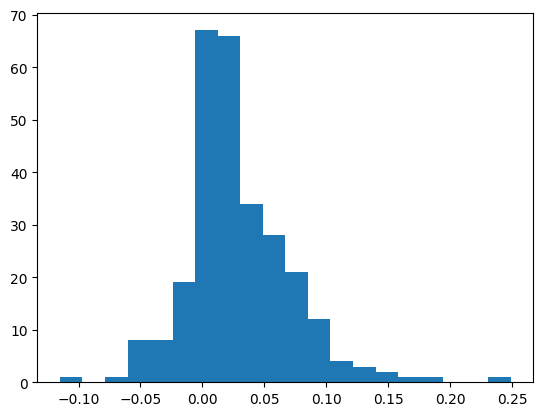

In [19]:
plt.hist(score_in_dataset, bins=20)

## Load Baseline Models

In [9]:
# inputs
input_folder = "/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/"
# input_folder = "F:/MASC/Ribhav_processed_dataset/"
# input_file = "Stranger Things’ Dacre Montgomery’s Insane _Billy_ Audition Tape ｜ GQ"
input_file = "Madelaine Petsch audition for The Prom"

input_scene_data_path = "/Users/evanpan/Documents/GitHub/Gaze_project/data/look_at_points/simplest_scene.json"
speaker_id = 1
shot_id = 1
turn_taking_threshold = 2
evaluation_fps = 24
np.random.seed(speaker_id + shot_id)


In [10]:
input_file_no_space = "_".join(input_file.split(" "))
# input_file_no_space = "'" + input_file_no_space + "'"
shot_file_name = os.path.join(os.path.join(os.path.join(input_folder, "shots"), input_file), "shot_cuts.json")
video_path = os.path.join(*[input_folder, "video", input_file+".mp4"])
audio_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.wav".format(shot_id, 1))
audio_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.wav".format(shot_id, 2))
script_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.txt".format(shot_id, 1))
script_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.txt".format(shot_id, 2))
praatoutput_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}_PraatOutput.txt".format(shot_id, 1))
praatoutput_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}_PraatOutput.txt".format(shot_id, 2))
head_direction_json_path = os.path.join(*[input_folder, "pose", input_file+".pkl"])
gaze_direction_json_path = os.path.join(*[input_folder, "L2CSNet", input_file+".json"])
landmarks_mediapipe_json_path = os.path.join(*[input_folder, "faces", input_file+" faces.pkl"])
python_out_location = os.path.join(*[input_folder, "outputs", input_file_no_space+".pkl"])
scene_file_out_location = os.path.join(*[input_folder, "annotated_scene", input_file+".json"])
animation_file_path = os.path.join(*[input_folder, "outputs", input_file+".pkl"])
animation_file_gaze_deploy_path = os.path.join(*[input_folder, "outputs", input_file+"_gaze_deploy.pkl"])
animation_file_static_salience_path = os.path.join(*[input_folder, "outputs", input_file+"_static_salience_map.pkl"])
animation_file_stare_location = os.path.join(*[input_folder, "outputs", input_file+"_stare.pkl"])


scene_data_path = os.path.join(*[input_folder, "annotated_scene", input_file+".json"])

# out_location = "/Users/evanpan/Documents/GitHub/Gaze_project/data/look_at_points/prototype2p2.pkl"
# out_location = "C:/Users/evansamaa/Documents/GitHub/Gaze_project/data/look_at_points/prototype2p2.pkl"

sementic_script_1 = Sentence_word_phone_parser(praatoutput_1_path, script_1_path)
# sementic_script_1.get_turns(turn_taking_threshold)
sementic_script_2 = Sentence_word_phone_parser(praatoutput_2_path, script_2_path)
# sementic_script_2.get_turns(turn_taking_threshold)
audio_1, sr= librosa.load(audio_1_path, sr=44100)
audio_2, sr= librosa.load(audio_2_path, sr=44100)
agentScene1 = AgentInfo(scene_data_path)
agentScene2 = AgentInfo(scene_data_path)

In [32]:
def load_animation(filepath):
    output_json = pkl.load(open(filepath, "rb"))
    predicted_eye_positions = output_json["eye_frames"] # ek is in local space
    predicted_head_angles = output_json["head_frames"] # hk are just angles
    ms = output_json["micro_saccade"]
    neck = output_json["other_neck"]
    envelope = output_json["envelope"]
    return predicted_eye_positions, predicted_head_angles, ms, neck, envelope
# load file
ek, hk, ms, neck, envelope = load_animation(animation_file_path)
gp_ek, gp_hk, gp_ms, gp_neck, gp_envelope = load_animation(animation_file_gaze_deploy_path)
ss_ek, ss_hk, ss_ms, ss_neck, ss_envelope = load_animation(animation_file_static_salience_path)
st_ek, st_hk, st_ms, st_neck, st_envelope = load_animation(animation_file_stare_location)
ek = np.array(ek)[0]
ts = ek[:, 0]
ek_interp = interp1d(ts, rotation_angles_frome_positions(ek[:, 1:]), axis=0, bounds_error=False)

gp_ek = np.array(gp_ek)[0]
gp_ts = gp_ek[:, 0]
gp_ek_interp = interp1d(gp_ts, rotation_angles_frome_positions(gp_ek[:, 1:]), axis=0, bounds_error=False)

ss_ek = np.array(ss_ek)[0]
ss_ts = ss_ek[:, 0]
ss_ek_interp = interp1d(ss_ts, rotation_angles_frome_positions(ss_ek[:, 1:]), axis=0, bounds_error=False)

st_ek = np.array(st_ek)[0]
st_ts = st_ek[:, 0]
st_ek_interp = interp1d(st_ts, rotation_angles_frome_positions(st_ek[:, 1:]), axis=0, bounds_error=False)

audio, sr = librosa.load(audio_1_path)

In [35]:
start = int(np.round(ss_ts[0] * evaluation_fps))
end = int(np.round((ss_ts[-1] - 5) * evaluation_fps))
times = np.arange(start, end) /evaluation_fps

# get aligned look-at-point positions
method_mine = ek_interp(times)
method_gd = gp_ek_interp(times)
method_ss = ss_ek_interp(times)
method_st = st_ek_interp(times)
score_mine = get_time_series_coefficient(audio, method_mine, evaluation_fps)
score_gd = get_time_series_coefficient(audio, method_gd, evaluation_fps)
score_ss = get_time_series_coefficient(audio, method_ss, evaluation_fps)
score_st = get_time_series_coefficient(audio, method_st, evaluation_fps)

print("{} is the score of my model".format(score_mine))
print("{} is the score of the gd model".format(score_gd))
print("{} is the score of the static saliency model".format(score_ss))
print("{} is the score of stare model".format(score_st))


-0.0028123031791083965 is the score of my model
0.007059301458164427 is the score of the gd model
0.0047731961607631575 is the score of the static saliency model
0.0004530360433676294 is the score of stare model


# Learn statistics from this Dataset (Distribution of gaze shifts with respect to beats)

## Relevant Functions

In [59]:
# iterative find audio onset between 0.2 and 0.6 seconds to identify beats
def get_beats(ts, audio_energy):
    beats = [[int(0), False]] # start with a pseudo beat
    daudio_dt = np.abs(dx_dt(audio_energy))
    Dm = 0.2
    DM = 0.6
    DM_frame = math.floor(DM / (ts[1] - ts[0]))
    for i in range(0, audio_energy.shape[0]):
        if daudio_dt[i] > 5:
            current_beat_t = ts[i]
            if current_beat_t - beats[-1][0] <= Dm:
                continue
            if current_beat_t - beats[-1][0] >= DM:
                # these are stored as integer indexes
                start = beats[-1][0]
                end = current_beat_t
                counter = start + DM_frame
                while counter < end:
                    beats.append([counter, False])
                    counter = counter + DM_frame
            beats.append([i, True])
    return beats
[sr, audio_onscreen, audio_offscreen], [fps, gaze, head, blinks], [file_name, shot_range] = dataset.get_video(0)
intensity = intensity_from_signal(audio_onscreen, int(sr/100))
ts = np.arange(0, intensity.shape[0])/100
beats = get_beats(ts, intensity)
print(beats)

[[0, False], [287, True]]
[0.000e+00 1.000e-02 2.000e-02 ... 9.257e+01 9.258e+01 9.259e+01]


In [12]:
dataset = SegmentDataset_SelfTape111(dataset_location)

In [13]:
# dataset = SegmentDataset_SelfTape111(dataset_location)
# matching_cov_values = []
# for shot_id in range(0, dataset):
#     [sr, audio_onscreen, audio_offscreen], [fps, gaze, head, blinks, aversion] = dataset[shot_id]
#     cor = get_time_series_coefficient(audio_onscreen, gaze, fps)
#     matching_cov_values.append(cor)

In [31]:
import whisper

model = whisper.load_model("tiny.en")
[sr, audio_onscreen, audio_offscreen], [fps, gaze, head, blinks], [file_name, shot_range] = dataset.get_video(0)
file_path = os.path.join(*[dataset_location, "audio", file_name+"_0.wav"])
result = model.transcribe(file_path, without_timestamps=False)

/Users/evanpan/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/whisper/transcribe.py:114: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [35]:
result["text"]

" Whoa, whoa, whoa, I'm Simon. Remember? We met like five times yesterday. We're in your desk class together. Oh, and you totally slept alone last night. I slept on the on the Papa's Aunt Chair. It's like a fish for us. I found you unconscious at the back of that bar last night. Yeah, I hear they've been a real problem in these parts lately. No, not exactly. And I couldn't call anyone for you because your phone was floating in. What I can only describe is the Coachella bodily fluids. And you wouldn't tell me where you live because apparently you're in a fight with your roommate or something. Is TNA a roommate? What do you want to use my phone to see if she's alright? Okay. Um, 933. Oh, sorry. All right. You have your essay? Yeah."

In [32]:
print(result["segments"][0].keys())

for i in range(0, len(result["segments"])):
    print(result["segments"][i]["text"], result["segments"][i]["start"], result["segments"][i]["end"], result["segments"][i]["no_speech_prob"])


dict_keys(['id', 'seek', 'start', 'end', 'text', 'tokens', 'temperature', 'avg_logprob', 'compression_ratio', 'no_speech_prob'])
 Whoa, whoa, whoa, I'm Simon. 0.0 5.0 0.035213958472013474
 Remember? 5.0 5.84 0.035213958472013474
 We met like five times yesterday. 5.84 9.0 0.035213958472013474
 We're in your desk class together. 9.0 11.0 0.035213958472013474
 Oh, and you totally slept alone last night. 11.0 16.68 0.035213958472013474
 I slept on the on the Papa's Aunt Chair. 16.68 19.6 0.035213958472013474
 It's like a fish for us. 19.6 23.0 0.035213958472013474
 I found you unconscious at the back of that bar last night. 23.0 28.0 0.035213958472013474
 Yeah, I hear they've been a real problem in these parts lately. 30.0 38.0 0.03702337667346001
 No, not exactly. 38.0 44.0 0.03702337667346001
 And I couldn't call anyone for you because your phone was floating in. 44.0 49.120000000000005 0.03702337667346001
 What I can only describe is the Coachella bodily fluids. 49.120000000000005 55.6